In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import json

from glob import glob
import os

from importlib import reload
from persim import PersistenceImager

import utils
import umap

from sklearn import decomposition, preprocessing, manifold

In [112]:
normtype = 'both'
level = 'sup'
sigma = 2
persw = 2
pixsz = 4
n_components = 12

nrows, ncols = 2,3
fs = 14; marker = ['D', 'o', 's']; color = ['red','cornflowerblue','gold']

seed = 42
SCALE = 256
ndims = 3
minlife = 0.5

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
dst = '..' + os.sep + 'infected_focus_summer24' + os.sep 
sample = 'D2'

dst += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
transcriptomes = np.asarray(list(metatrans['gene']))

gsrc = '../{}level/'.format(level)
gsrc += sample + os.sep

Cells = utils.get_range_cell_values(dst + 'infected_cells_ids.csv', metacell, startval=1)
Genes = utils.get_range_gene_values(dst + 'genes_to_focus_infection.csv', transcriptomes, startval=0)

foo = glob(gsrc + transcriptomes[Genes[0]] + os.sep + '*')[0]
bar = os.path.split(foo)[1].split('_')
PP = int(bar[4][1:])
stepsize = int(bar[5][1:])
bw = int(bar[6][2:])

transfocus = transcell.loc[Genes, Cells.astype(str)]
ratios = utils.normalize_counts(transfocus, normtype)
if ratios is None:
    print('ERROR')

print('Max ratio by {}:\t{:.2f}%'.format(normtype, 100*np.max(ratios) ) )
transfocus

Max ratio by both:	0.24%


,742,842,2052,1145,896,2152,558,751,746,236,...,303,1782,1724,1571,1583,1454,2430,1143,752,513
85,363,1247,1026,572,938,1185,531,1819,984,1314,...,228,156,48,62,107,132,49,86,138,371
28,5,17,15,26,17,32,20,15,11,23,...,3,0,0,1,4,1,0,2,4,7
84,1,10,12,7,18,13,6,24,4,27,...,6,5,1,3,8,11,1,7,6,19
27,0,0,1,2,0,0,0,0,1,2,...,8,0,0,0,0,0,0,2,0,1
74,7,19,12,11,12,17,8,11,21,20,...,7,3,1,1,1,2,0,5,3,8
26,249,317,582,307,195,1026,529,687,341,694,...,439,406,187,183,271,241,62,152,396,806


In [3]:
print(np.sum(ratios > 0, axis=1))
jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]

for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

[968 950 956 464 960 968]


In [4]:
orig_diags = [None for i in range(len(jsonfiles))]
for i in range(len(orig_diags)):
    orig_diags[i] = utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True)

numpairs = 0
genemaxk = np.zeros((len(orig_diags), ndims))
maxlife = np.zeros((len(orig_diags), len(orig_diags[0]), len(orig_diags[0][0])))

# [gene][cell][dimension]

for i in range(len(orig_diags)):
    for j in range(len(orig_diags[i])):
        for k in range(len(orig_diags[i][j])):
            orig_diags[i][j][k] *= ratios[i][j]
            numpairs += len(orig_diags[i][j][k])
            if len(orig_diags[i][j][k]) > 0:
                maxlife[i,j,k] = orig_diags[i][j][k][0,1] - orig_diags[i][j][k][0,0]
                if genemaxk[i,k] < np.max(orig_diags[i][j][k]):
                    genemaxk[i,k] = np.max(orig_diags[i][j][k])

print('Initial number of life-birth pairs\t:', numpairs)
# timepoint != lifetime

if normtype == 'gene':
    maxx = np.max(genemaxk,axis=1).reshape(len(maxlife),1,1)
elif normtype == 'both':
    maxx = np.max(genemaxk) 

rescale = SCALE/maxx
maxlife *= rescale
argmaxlife = np.argmax(maxlife, axis=-1)
print(np.histogram(argmaxlife.ravel(), bins=range(ndims+1)))

for i in range(len(orig_diags)):
    foo = np.sum(transfocus.loc[Genes[i]].values)
    print(i, transcriptomes[Genes[i]], foo, np.max(maxlife[i]), sep='\t')

Initial number of life-birth pairs	: 159902
(array([5748,   60,    0]), array([0, 1, 2, 3]))
0	GLYMA_17G195900	698882	93.11415035159283
1	GLYMA_05G216000	12919	17.15245646006293
2	GLYMA_17G185800	11462	27.339467611397176
3	GLYMA_05G203100	4116	25.366710912806596
4	GLYMA_15G210100	11688	18.18916961007017
5	GLYMA_05G092200	479091	187.53698751974602


In [5]:
mhist, _ = np.histogram(argmaxlife.ravel(), bins=range(ndims+1))
focus_dim = np.argmax(mhist)

if normtype == 'gene':
    diags = [ [ rescale[i][0][0]*orig_diags[i][j][focus_dim].copy() for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
elif normtype == 'both':
    diags = [ [ rescale*orig_diags[i][j][focus_dim].copy() for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]

for i in range(len(diags)):
    for j in range(len(diags[i])):
        diags[i][j] = np.atleast_2d(diags[i][j][ diags[i][j][:,1] - diags[i][j][:,0] > minlife, : ])

nonzerodiags = np.zeros(1+len(diags), dtype=int)
nzmask = [None for i in range(len(diags)) ]

for i in range(len(diags)):
    nzmask[i] = np.nonzero( np.array(list(map(len, diags[i]))) > 1  )[0]
    nonzerodiags[i+1] += len(nzmask[i])
    diags[i] = [ diags[i][j] for j in nzmask[i] ]

nzcumsum = np.cumsum(nonzerodiags)
lt_coll = [ None for _ in range(nzcumsum[-1]) ]

k = 0
maxbirth = 0
for i in range(len(diags)):
    for j in range(len(diags[i])):
        lt_coll[k] = np.column_stack( (diags[i][j][:, 0], diags[i][j][:, 1] - diags[i][j][:, 0]) )
        foo = np.max(diags[i][j][:, 0])
        if foo > maxbirth:
            maxbirth = foo
        k += 1

foo = nzcumsum[-1]/(len(diags)*len(diags[0]))*100
print('Non-zero diagrams:\t', nzcumsum[-1],'\nCompared to all diagrams:\t',len(diags)*len(diags[0]),'\t[{:.2f}%]'.format(foo), sep='')

Non-zero diagrams:	4783
Compared to all diagrams:	5808	[82.35%]


# Persistence Images

In [6]:
pi_params = {'birth_range':(0,min([SCALE, maxbirth + 10])),
             'pers_range':(0,min([SCALE,maxlife[:,:,focus_dim].max()+10])),
             'pixel_size': pixsz,
             'weight': 'persistence',
             'weight_params': {'n': persw},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                           
pimgr = PersistenceImager(**pi_params)
extent = [ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ]

In [7]:
img = np.asarray(pimgr.transform(lt_coll, skew=False))

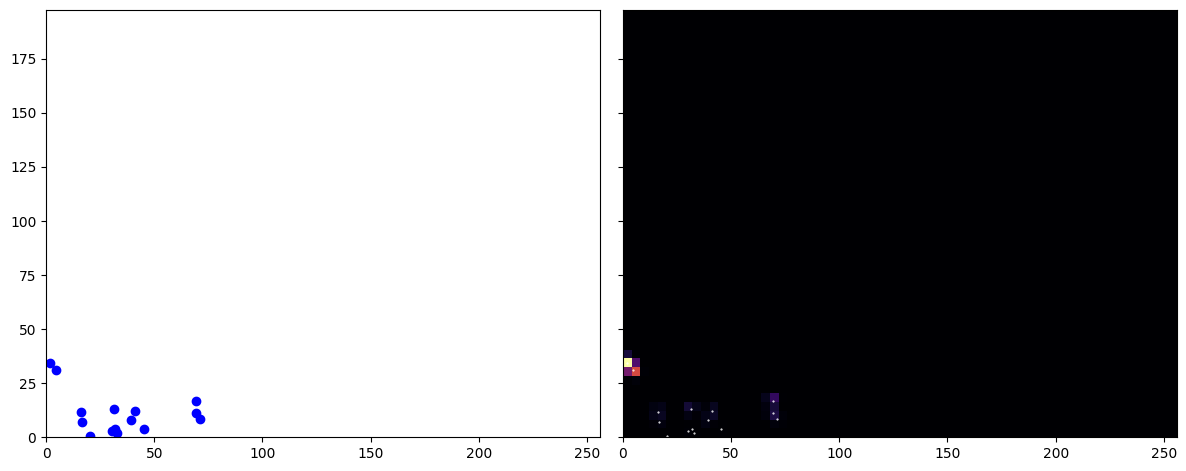

In [8]:
k = 908
fig, ax = plt.subplots(1,2, figsize=(12,5.5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(lt_coll[k][:,0], lt_coll[k][:,1], c='b')
ax[i].set_aspect('equal'); i+=1
ax[i].imshow(img[k].T, cmap='inferno', vmin=0, origin='lower', extent=extent)
ax[i].scatter(lt_coll[k][:,0], lt_coll[k][:,1], c='w', marker='.', s=1)

fig.tight_layout();

# Explore

In [124]:
bname = '{}level_-_by_{}_-_sigma_{}_-_persn_{}_-_px_{}'.format(level,normtype,sigma,persw,pixsz)
Bname = '{}level persistence. {} normalized. $\sigma = {}$. Weighted by $n^{}$. '.format(level.title(),normtype.title(),sigma,persw)
tdst = dst + bname + os.sep
if not os.path.isdir(tdst):
    os.mkdir(tdst)

In [9]:
avg = np.zeros( (len(nzcumsum) - 1, pimgr.resolution[1], pimgr.resolution[0]))
for i in range(len(avg)):
    s_ = np.s_[nzcumsum[i]:nzcumsum[i+1]]
    avg[i] = np.mean(img[s_], axis=0).T

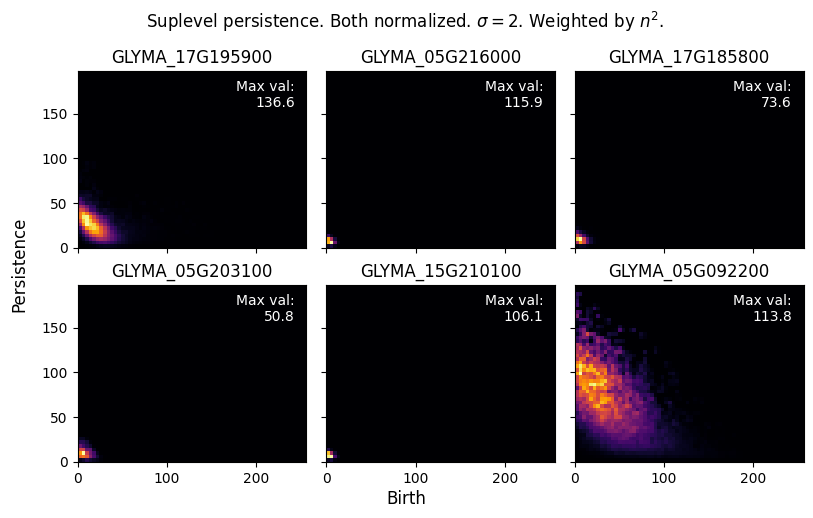

In [125]:
dpi = 96
fig, ax = plt.subplots(nrows, ncols, figsize=(2.75*ncols, 2.15*nrows+1), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(nzcumsum)-1):
    ax[i].imshow(avg[i], cmap='inferno', origin='lower', vmin=0,  extent=extent)
    ax[i].text((extent[1] - extent[0])*.95, (extent[3] - extent[2])*.95, 
               'Max val:\n{:.1f}'.format(np.max(avg[i])), color='w', ha='right', va='top')
    ax[i].set_title(transcriptomes[Genes[i]])

for i in range( len(ax) - len(nzcumsum)+1 , 0, -1):
    fig.delaxes(ax[-i])

fig.supxlabel('Birth', y=.04); 
fig.supylabel('Persistence')
fig.suptitle(Bname)

fig.tight_layout()
filename = tdst + 'average_persistence_images'
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# Reduce dimension

In [116]:
colors = ['r','b','forestgreen','magenta','gold','cyan','brown','orange']
markers = ['o','d', '^','v','s','D','p','<','>']

pi = img.reshape(img.shape[0], img.shape[1]*img.shape[2])
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(pi)

In [129]:
def plot_embedding(embedding, alpha=0.05, title=None, nrows=2, ncols=4):
    q1, q3 = np.quantile(embedding[:,:2], [alpha, 1-alpha], axis=0)
    iqr = q3 - q1
    mn = np.maximum( q1 - 1.5*iqr, np.min(embedding[:,:2], axis=0) )
    mx = np.minimum( q3 + 1.5*iqr, np.max(embedding[:,:2], axis=0) )
        
    fig, ax = plt.subplots(nrows, ncols, figsize=(3*ncols,2*nrows+1), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel()
    
    for i in range(len(nzcumsum) - 1):
        ax[i].scatter(embedding[:,0], embedding[:,1], c='gray', marker='.', alpha=0.15, zorder=1)
        ax[i].set_facecolor('snow')
        s_ = np.s_[nzcumsum[i]:nzcumsum[i+1]]
        ax[i].scatter(embedding[s_,0], embedding[s_,1], c=colors[i], marker=markers[i], alpha=0.5, zorder=2)
        ax[i].set_title(transcriptomes[Genes[i]])
        ax[i].set_xlim(mn[0],mx[0]);ax[0].set_ylim(mn[1],mx[1])
        ax[i].tick_params(left=False, labelleft=False, labelbottom=False, bottom=False);
    
    for i in range( len(ax) - len(nzcumsum)+1 , 0, -1):
        fig.delaxes(ax[-i])

    if title is not None:
        fig.supxlabel(title + ' 01')
        fig.supylabel(title + ' 02')
    
    fig.tight_layout();

    return fig, ax

# PCA

In [187]:
PCA = decomposition.PCA(n_components=n_components, random_state=seed)
pca = PCA.fit_transform(data).astype('float32')
print(100*PCA.explained_variance_ratio_)

[15.91429525  8.06616337  7.74711968  3.05612114  2.78881036  2.67241087
  2.3221356   2.23684824  2.10277621  1.90216628  1.71452866  1.61589793]


/tmp/ipykernel_43420/2534277463.py:7: UserWarning: The figure layout has changed to tight
  fig.tight_layout();


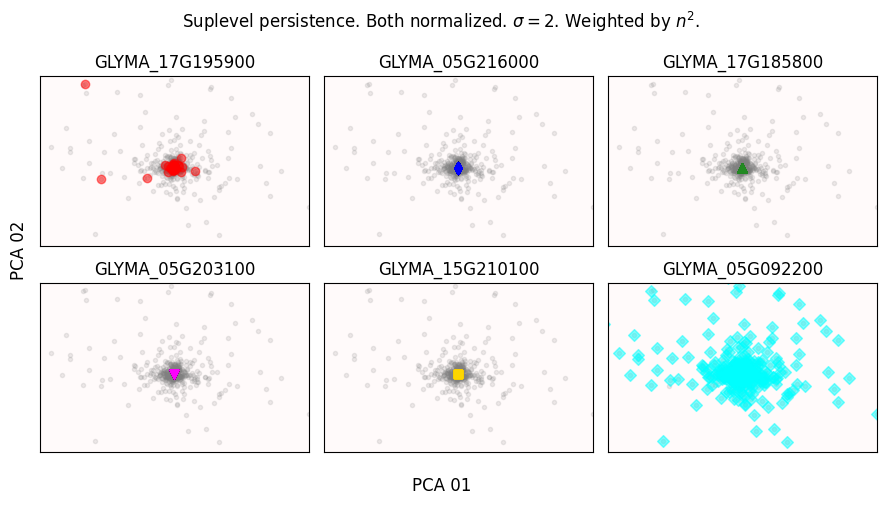

In [188]:
method = 'PCA'
bname = '{}'.format(method.lower())
np.save(tdst+bname+'.npy', pca, allow_pickle=True)

fig, ax = plot_embedding(pca, 0.01, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# Locally Linear Embeddings

In [146]:
n_neighbors = 12  # neighborhood which is used to recover the locally linear structure
params = {"n_neighbors": n_neighbors,"n_components": n_components,"eigen_solver": "auto","random_state": seed}
LLE = manifold.LocallyLinearEmbedding(method="standard", **params)
lle = LLE.fit_transform(data).astype('float32')

lle_-_method_standard_-_n+neighbors_12


/tmp/ipykernel_43420/2749555312.py:9: UserWarning: The figure layout has changed to tight
  fig.tight_layout();


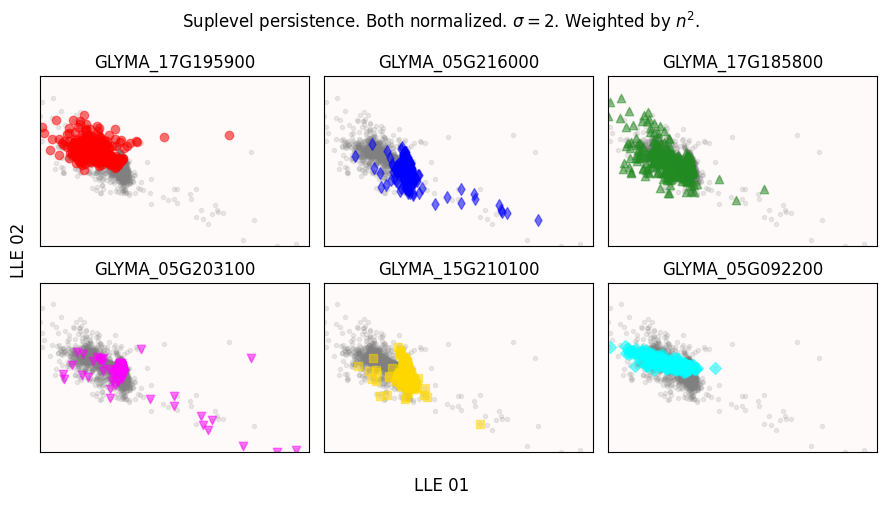

In [186]:
params = LLE.get_params()
method = 'LLE'
bname = '{}_-_method_{}_-_n+neighbors_{}'.format(method.lower(), LLE.method, params['n_neighbors'])
print(bname)
np.save(tdst+bname+'.npy', lle, allow_pickle=True)

fig, ax = plot_embedding(lle, 0.01, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# tSNE

In [159]:
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=30,
    init="random",
    n_iter=250,
    random_state=seed,
)
tsne = t_sne.fit_transform(data).astype('float32')

tsne_-_perplexity_30_-_init_random_-_n+iter_250


/tmp/ipykernel_43420/3034125373.py:9: UserWarning: The figure layout has changed to tight
  fig.tight_layout();


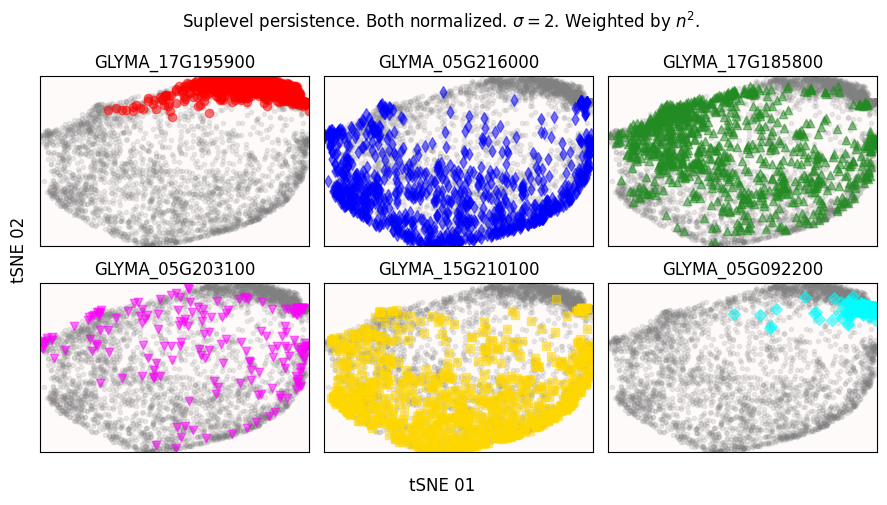

In [184]:
params = t_sne.get_params()
method = 'tSNE'
bname = '{}_-_perplexity_{}_-_init_{}_-_n+iter_{}'.format(method.lower(), params['perplexity'], params['init'],params['n_iter'])
print(bname)
np.save(tdst+bname+'.npy', tsne, allow_pickle=True)

fig, ax = plot_embedding(tsne, 0.01, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# UMAP

In [169]:
ufit = umap.UMAP(n_neighbors=12, min_dist=0.1, n_components=n_components, metric='euclidean', random_state=seed)
u_umap = ufit.fit_transform(data);

/home/eah4d/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


umap_-_n+neighbors_12_-_min+dist_0.1_-_metric_euclidean


/tmp/ipykernel_43420/1327569144.py:8: UserWarning: The figure layout has changed to tight
  fig.tight_layout();


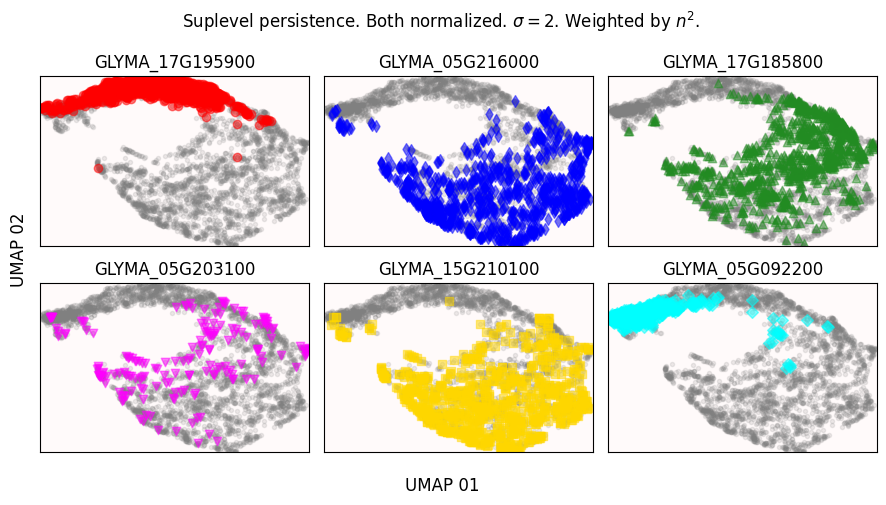

In [171]:
params = ufit.get_params();
method = 'UMAP'
bname = '{}_-_n+neighbors_{}_-_min+dist_{}_-_metric_{}'.format(method.lower(), params['n_neighbors'], params['min_dist'],params['metric'])
print(bname)
np.save(tdst+bname+'.npy', u_umap, allow_pickle=True)

fig, ax = plot_embedding(u_umap, 0.01, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')